# Pryngles module: Spangling

In [17]:
from pryngles import *

## External modules

In [29]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib nbagg

## Spangling class

In [19]:
Spangling_doc=f"""\
    Fibonacci sampling of disks and spheres used to generate spangles position.
    This class and module is based on fibpy by Martin Roberts, source code: 
    https://github.com/matt77hias/fibpy
    
    Initialization attributes:
        N: integer:
            Number of spangles.
        
    Optional attibutes:
    
        seed: integer. default = 0:
            Value of the integer seed of random number generation (if 0 no random seed is set).
            If a non-zero seed is used the position of the spangles for a given geometri will be 
            always the same.
        
    Secondary attributes:
    
        dim: integer. 
            Dimension of spangling.
            
        ss: numpy array (Nx3).
            Position of the spangles in cartesian coordinates, 
            
        pp: numpy array (Nx3).
            Position of the spangles in polar or spherical coordinates (r,phi,theta), 
            where phi is azimutal angle and theta is elevation (complement of polar angle).
            
        purged: boolean. default = False:
            Is the spangling purged?.  Purge is the process by which spangles too close are
            removed until the average distance between points is similar.
        
        dmin, dmed, dmax: float
            Minimum, median and maximum distance between spangles.
        
        ds: numpy array (N).
            Distance to the nearest neighbor for all the spangles.
            
        dran: float.
            Range of distances between spangles (dmax-dmin).  While the smaller this quantity the better.
            
        dstar: float.
            As measure of distances (sqrt(N)*dmed). Typically this value is between 2.4 and 3.4
            (see source http://extremelearning.com.au/evenly-distributing-points-on-a-sphere)

    Other attributes:
    
        cargs: dictionary.  default = dict(color="k",fill=False,alpha=0.3): 
            Arguments for plotting the circumference in polar.
                   
        wargs: dictionary. default = dict(color="k",lw=0.1): 
            Arguments for plotting a sphere in 3d space.
"""

In [30]:
class Spangling(object):
    def __init__(self,N,seed=0):
        #Basic
        self.N=N
        
        #Derivative
        self.dim=0
        self.ss=None
        self.pp=None
        self.dmin=self.dmed=self.dmax=self.dran=self.dstar=0
        
        #Purge
        self.purged=False
        
        #Plotting
        self.cargs=dict(color="k",fill=False,alpha=0.3)
        self.wargs=dict(color="k",lw=0.1)
        
        #Random seed
        if seed:
            np.random.seed(seed)
            
    def gen_circle(self,perturbation=1,boundary=2):
        """
        Sample points in fibonacci spiral on the unit circle
        
        Optional parameters:
            
            perturbation: type of perturbation (0 normal perturbation, 1 random perturbation), int
            
            boundary: type of boundary (0 jagged, >1 smooth)
            
        Update:
            ss, pp
        """
        shift = 1.0 if perturbation == 0 else self.N*np.random.random()

        ga = np.pi * (3.0 - np.sqrt(5.0))

        # Boundary points
        np_boundary = round(boundary * np.sqrt(self.N))

        self.dim=2
        self.ss = np.zeros((self.N,self.dim))
        self.pp = np.zeros((self.N,self.dim))
        j = 0
        for i in range(self.N):
            if i > self.N - (np_boundary + 1):
                r = 1.0
            else:
                r = np.sqrt((i + 0.5) / (self.N - 0.5 * (np_boundary + 1)))
            phi   = ga * (i + shift)
            self.ss[j,:] = np.array([r * np.cos(phi), r * np.sin(phi)])
            self.pp[j,:] = np.array([r,np.mod(phi,2*np.pi)])
            j += 1
            
        #Distances
        self._calc_distances()

    def gen_circle_gaps(self,gaps,perturbation=1,boundary=2):
        """
        Sample points in fibonacci spiral on the unit circle, but including gaps (as in rings)
        
        Parameters:
            gaps: description of the position of gaps in the form [(R1,dR1),(R2,dR2),...], List of tuples.
        
        Optional parameters:
            perturbation: type of perturbation (0 normal perturbation, 1 random perturbation), int
            boundary: type of boundary (0 jagged, >1 smooth)
            
        Example:
            s.Sample(1000)
            s.gen_circle_gaps([(0,0.2),(0.5,0.2),[0.8,0.1]])
            
        Update:
            ss, pp
        """
        shift = 1.0 if perturbation == 0 else self.N*np.random.random()
        ga = np.pi * (3.0 - np.sqrt(5.0))

        self.dim=2
        Ntest = self.N
        Nacc = 0

        while Nacc < self.N:        

            # Boundary points
            np_boundary = round(boundary * np.sqrt(Ntest))

            ss = []
            pp = []
            j = 0
            for i in range(Ntest):
                if i > Ntest - (np_boundary + 1):
                    r = 1.0
                else:
                    r = np.sqrt((i + 0.5) / (Ntest - 0.5 * (np_boundary + 1)))

                skip = False
                for gap in gaps:
                    if gap[0]<=r<=(gap[0]+gap[1]):
                        skip = True
                if skip:continue

                phi   = ga * (i + shift)
                ss += [np.array([r * np.cos(phi), r * np.sin(phi)])]
                pp += [np.array([r,np.mod(phi,2*np.pi)])]
                j += 1
            Nacc = j
            Ntest += int((Ntest-Nacc)/len(gaps))
            
        self.ss=np.array(ss)
        self.pp=np.array(pp)
        self.N=Nacc

        #Distances
        self._calc_distances()

    def gen_sphere(self,perturbation=1):
        """
        Sample points in the unit sphere following fibonacci spiral
        
        Optional parameters:
            perturbation: type of perturbation (0 normal perturbation, 1 random perturbation), int
            
        Update:
            ss, pp
        """

        shift = 1.0 if perturbation == 0 else self.N * np.random.random()

        ga = np.pi * (3.0 - np.sqrt(5.0))
        offset = 2.0 / self.N
        
        self.dim=3
        self.ss = np.zeros((self.N,self.dim))
        self.pp = np.zeros((self.N,self.dim))
        j = 0
        for i in range(self.N):
            phi   = ga * ((i + shift) % self.N)
            cos_phi = np.cos(phi)
            sin_phi = np.sin(phi)
            cos_theta = ((i + 0.5) * offset) - 1.0
            sin_theta = np.sqrt(1.0 - cos_theta*cos_theta)
            theta=np.arccos(cos_theta)            
            self.ss[j,:] = np.array([cos_phi * sin_theta, sin_phi * sin_theta, cos_theta])
            self.pp[j,:] = np.array([1,np.mod(phi,2*np.pi),np.pi/2-theta])
            j += 1

        #Distances
        self._calc_distances()
            
    def purge_sample(self,tol=0.5):
        """
        Purge sample, ie. remove points close than a given threshold.
        
        Optional parameters:
            tol: distance to purge, ie. if dmin<tol*dmed then purge, float
            
        Update:
            ss, pp, N, _purge
        """
        if self.purged:
            print("Already purged.")
            return 0
        
        self.purged=False
        purge=True
        while purge:
            self._calc_distances()
            if self.dmin<tol*self.dmed:
                ipurge=np.argsort(self.ds)[0]
                self.ss=np.delete(self.ss,ipurge,0)
                self.pp=np.delete(self.pp,ipurge,0)
                self.N-=1
                self.purged=True
                purge=True
            else:
                purge=False
                
    def _get_min_distance(self,r,rs):
        """
        Get the minimum distance from point r to points rs
        
        Parameter:
            r: numpy array (3):
                coordinates of the point.
            rs: numpy array (N)
                coordinates of the points.
        
        Return:
            dmin: float
                minimum distance.
        """
        deltas=rs-r
        dist=np.einsum('ij,ij->i',deltas,deltas)
        imin=np.argsort(dist)[1]
        return np.sqrt(dist[imin])

    def _calc_distances(self):
        """
        Calculate the minimum distances of all points in the sample.
        
        Update:
            ds,dmin,dmax,dmed,dran,dstar.
        """
        self.ds=np.array([self._get_min_distance(self.ss[i],self.ss) for i in range(len(self.ss))])
        self.dmin=self.ds.min()
        self.dmax=self.ds.max()
        self.dmed=np.median(self.ds)
        self.dran=self.dmax-self.dmin
        self.dstar=np.sqrt(self.N)*self.dmed

    def plot_sample(self,**args):
        """
        Plot sample.
        
        Parameters:
            args: scatter plotting options, dictionary.
        """
        sargs=dict(c='k',s=1.5)
        sargs.update(args)
        if self.dim==2:            
            self.fig,self.ax=plt.subplots()
            self.ax.scatter(self.ss[:,0],self.ss[:,1],**sargs)
            self.ax.add_patch(plt.Circle((0,0),1,**self.cargs))
            self.ax.set_aspect("equal")
        else:
            self.fig=plt.figure()
            self.ax=self.fig.add_subplot(111,projection='3d')
            self.ax.scatter(self.ss[:,0],self.ss[:,1],self.ss[:,2],**sargs)
            u,v=np.mgrid[0:2*np.pi:20j,0:np.pi:10j]
            x=np.cos(u)*np.sin(v)
            y=np.sin(u)*np.sin(v)
            z=np.cos(v)
            self.ax.plot_wireframe(x,y,z,**self.wargs)
            self.ax.set_box_aspect([1,1,1])
            
Spangling.__doc__=Spangling_doc

0.09777409588068321 0.10641060654838054 0.11025145618170576 0.012477360301022547 3.3430547950304854 987


<IPython.core.display.Javascript object>


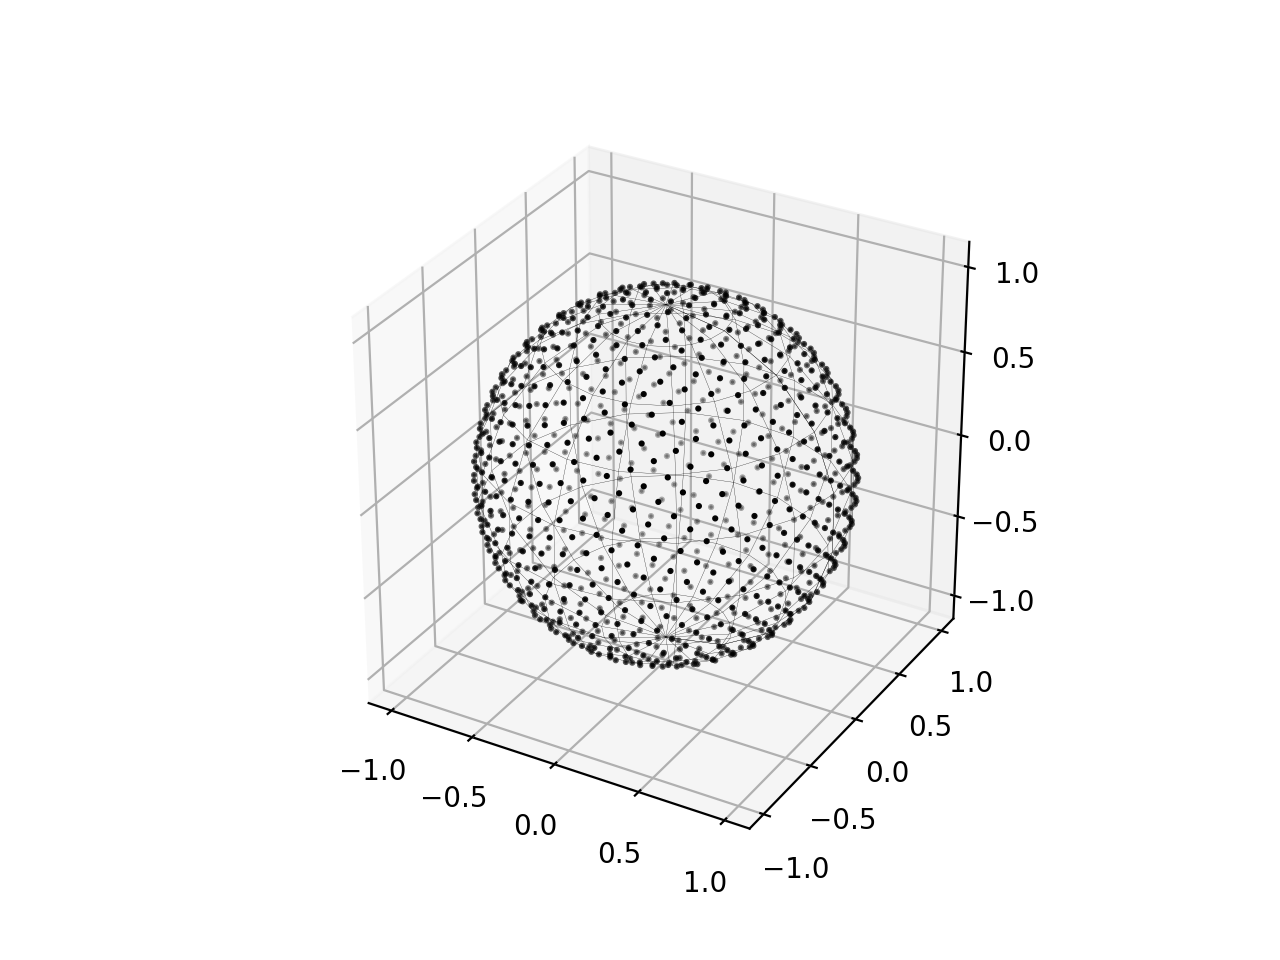

E
ERROR: test_sample (__main__.Test)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/var/folders/sv/555plv5x3370zvjrhxl6vf100000gn/T/ipykernel_91541/2424287629.py", line 14, in test_sample
    S.algo()
AttributeError: 'Spangling' object has no attribute 'algo'

----------------------------------------------------------------------
Ran 1 test in 0.944s

FAILED (errors=1)


In [39]:
if IN_JUPYTER:
    def test_sample(self):
        #Create
        S=Spangling(1000,seed=10)
        
        #Generate
        #S.gen_circle()
        #S.gen_circle_gaps([[0.3,0.05],[0.5,0.05]])
        S.gen_sphere()

        S.purge_sample()
        print(S.dmin,S.dmed,S.dmax,S.dran,S.dstar,S.N)
        S.plot_sample()
        """
        self.assertEqual(np.isclose([P.physics.wrot],
                                    [2*np.pi/PlanetDefaults.physics["prot"]],
                                    rtol=1e-7),
                         [True]*1)
        #Check exception: primary could not be different from None or Body
        self.assertRaises(AssertionError,lambda:Observer(primary="Nada"))
        """
        
    class Test(unittest.TestCase):pass    
    Test.test_sample=test_sample
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

--End--